In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten,MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import predict
import optuna

In [2]:
dataset=pd.read_csv('SolarPrediction_aligned_Sun.csv',engine='python',nrows=576*15)
dataset=dataset.drop("Data",axis=1)
dataset=dataset.drop("Time",axis=1)
# dataset=dataset.drop("TimeSunRise",axis=1)
# dataset=dataset.drop("TimeSunSet",axis=1)
target=dataset["Radiation"]
dataset.head(5)


,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,8,2.58,51,30.43,103,77.27,11.25,22020,67080
1,310,2.83,51,30.43,103,153.44,9.00,22020,67080
2,1206,2.16,51,30.43,103,142.04,7.87,22020,67080
3,1505,2.21,51,30.43,103,144.12,18.00,22020,67080
4,1809,2.25,51,30.43,103,67.42,11.25,22020,67080


In [3]:
dataset=dataset.values
dataset[:,1]

array([  2.58,   2.83,   2.16, ..., 344.9 , 365.66, 355.57])

In [4]:


dataset=dataset.astype('float32')

scalar1=MinMaxScaler(feature_range=(0,1))
scalar2=MinMaxScaler(feature_range=(0,1))
scalar_dim=dataset[:,1]
dataset=scalar1.fit_transform(dataset)

scalar_dim=scalar_dim.reshape(len(dataset),1)
print(scalar_dim)
scalar_dim=scalar2.fit_transform(scalar_dim)
print(scalar_dim)


[[  2.58]
 [  2.83]
 [  2.16]
 ...
 [344.9 ]
 [365.66]
 [355.57]]
[[0.00089369]
 [0.00104993]
 [0.00063121]
 ...
 [0.21482898]
 [0.2278031 ]
 [0.22149728]]


In [5]:
train_size=int(len(dataset)*0.67)
test_size=len(dataset)- train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]

print(train.shape)
print(train)
print(test.shape)
#print(test)

(5788, 9)
[[5.8056499e-05 8.9368853e-04 3.3333325e-01 ... 5.5555558e-01
  0.0000000e+00 1.0000000e+00]
 [3.5646691e-03 1.0499278e-03 3.3333325e-01 ... 4.4444445e-01
  0.0000000e+00 1.0000000e+00]
 [1.3968393e-02 6.3120667e-04 3.3333325e-01 ... 3.8864198e-01
  0.0000000e+00 1.0000000e+00]
 ...
 [1.7786188e-01 4.3747015e-05 2.6666665e-01 ... 2.2222222e-01
  7.1428680e-01 2.9999924e-01]
 [1.8134527e-01 5.6246121e-05 2.6666665e-01 ... 2.7753085e-01
  7.1428680e-01 2.9999924e-01]
 [1.8480544e-01 6.2495703e-05 2.6666665e-01 ... 2.2222222e-01
  7.1428680e-01 2.9999924e-01]]
(2852, 9)


In [6]:
def create_dataset(dataset,look_back):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        #a=dataset第0行i~i+look_back個
        a=dataset[i:(i+look_back),0:9]
        dataX.append(a)
        dataY.append(dataset[i+look_back,1])
    return np.array(dataX),np.array(dataY)

    

In [7]:
#根據前面幾個資料來看下一步 彙整成look_back行的資料
#X用以輸入 Y用用以predict
look_back=5
trainX,trainY=create_dataset(train,look_back)
testX,testY=create_dataset(test,look_back)
print(testX.shape)
#print(testX)
print(testY.shape)
print(trainX.shape)
print(trainY.shape)


(2846, 5, 9)
(2846,)
(5782, 5, 9)
(5782,)


In [8]:
model = Sequential()
model.add(Conv1D(filters=111, kernel_size=3, activation='relu', input_shape=(look_back, 9)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(148, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')


In [9]:
model.fit(trainX, trainY, epochs=30, batch_size=1, validation_data=(testX, testY))

Epoch 1/30
5782/5782 [==============================] - 15s 2ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 2/30
5782/5782 [==============================] - 15s 3ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 3/30
5782/5782 [==============================] - 15s 3ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 4/30
5782/5782 [==============================] - 17s 3ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 5/30
5782/5782 [==============================] - 15s 3ms/step - loss: 0.0049 - val_loss: 0.0060
Epoch 6/30
5782/5782 [==============================] - 15s 3ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 7/30
5782/5782 [==============================] - 16s 3ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 8/30
5782/5782 [==============================] - 16s 3ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 9/30
5782/5782 [==============================] - 14s 2ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 10/30
5782/5782 [==============================] - 16s 3ms/step - l

In [10]:
trainPre=model.predict(trainX)
testPre=model.predict(testX)
trainPre.shape
testPre.shape

89/89 [==============================] - 0s 2ms/step


(2846, 1)

In [11]:
trainPre=scalar2.inverse_transform(trainPre)
trainY_ord=scalar2.inverse_transform([trainY])
testPre=scalar2.inverse_transform(testPre)
testY_ord=scalar2.inverse_transform([testY])
print(trainPre.shape)
print(trainY.shape)
print(testPre.shape)
print(testY.shape)

(5782, 1)
(5782,)
(2846, 1)
(2846,)


In [12]:
trainScore=math.sqrt(mean_squared_error(trainY_ord[0,:],trainPre[:,0]))
print('Train Score:%.2f RMSE'%(trainScore))
testScore=math.sqrt(mean_squared_error(testY_ord[0,:],testPre[:,0]))
print('Test Score:%.2f RMSE'%(testScore))
MAE=mean_absolute_error(testY_ord[0,:],testPre[:,0])
print('Test Score:%.2f MAE'%(MAE))

Train Score:100.86 RMSE
Test Score:103.76 RMSE
Test Score:54.32 MAE


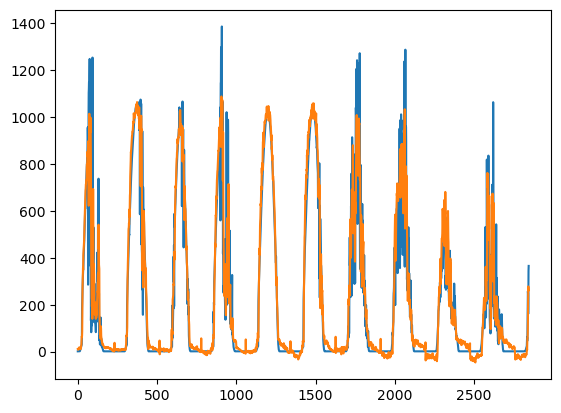

In [13]:
trainPredictplot=np.empty_like(scalar_dim)
trainPredictplot[:,:]=np.nan
trainPredictplot[look_back:len(trainPre)+look_back,:]=trainPre

testPredictPlot=np.empty_like(scalar_dim)
testPredictPlot[:,:]=np.NaN
testPredictPlot[len(trainPre)+(look_back*2)+1:len(dataset)-1,:]=testPre
    
#plt.subplot(311)
plt.cla()
#plt.plot(scalar2.inverse_transform(scalar_dim),label='Ground Truth')
plt.plot(testY_ord[0,:],label='Ground Truth')
#plt.plot(trainPredictplot,label='Prediction(training)')
plt.plot(testPre[:,0],label='Prediction(testing)')


MAE: 54.32
RMSE: 103.76
R2 Score: 0.9
MAE: 54.32
RMSE: 103.76
R2 Score: 0.9
MAE: 54.32
RMSE: 103.76
R2 Score: 0.9


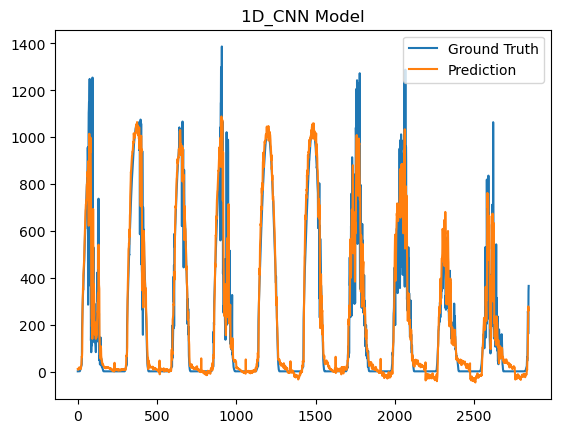

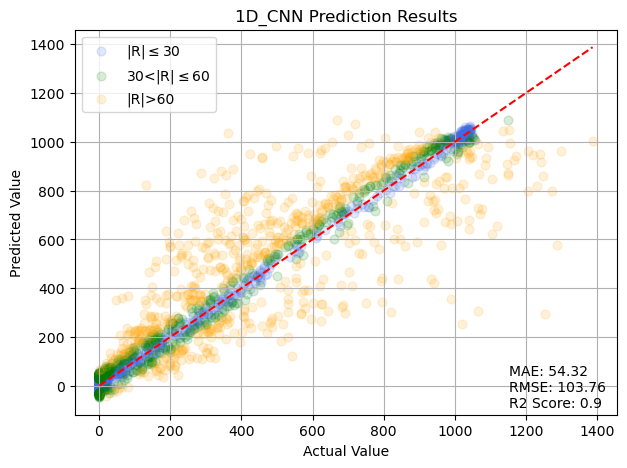

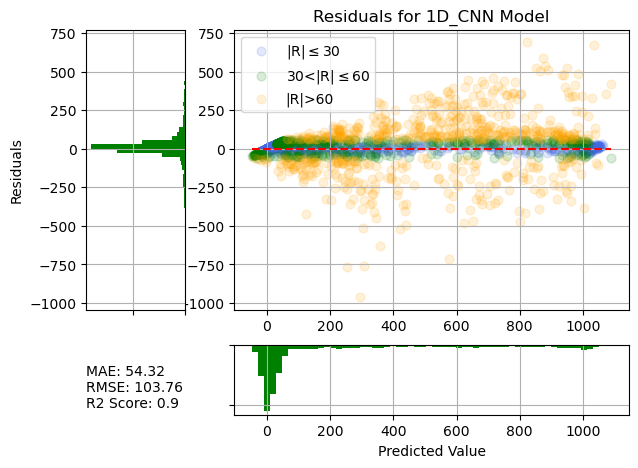

In [14]:
predict.my_self(testY_ord[0,:],testPre[:,0],'1D_CNN')
predict.score_calculation(testY_ord[0,:],testPre[:,0])
predict.plot_pred(testY_ord[0,:],testPre[:,0],'1D_CNN')
predict.plot_residuals(testY_ord[0,:],testPre[:,0],'1D_CNN')